In [226]:
from tensorflow.keras.layers import Input, Dense, Embedding, Conv1D, LeakyReLU, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import L2

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, accuracy_score
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [14]:
df = pd.read_csv('../data/clean_data.csv', index_col='Municipality')

# Get proper label
labels = df.filter(like='catalan')
label = df.filter(like='catalan').filter(like='speak')
data = df.drop(list(labels.columns), axis=1)

label[:] = pd.qcut(label['culture_knowledge_of_catalan_speak'], q=4, labels=[0,1,2,3])
label[label['culture_knowledge_of_catalan_speak'] == 2] = 1
label[label['culture_knowledge_of_catalan_speak'] == 3] = 2

label_data = pd.get_dummies(label['culture_knowledge_of_catalan_speak'])
label_data = label_data.drop(3, axis=1)
label_data_size = label_data.shape

data = data.drop(['missing_count'], axis=1)
data['population_population_by_sex_main'] = pd.Categorical(data['population_population_by_sex_main'])
data['population_population_by_sex_main'] = data['population_population_by_sex_main'].cat.codes.astype(float)

data['economic_sectors_head_of_livestock_main'] = pd.Categorical(data['economic_sectors_head_of_livestock_main'])
data['economic_sectors_head_of_livestock_main'] = data['economic_sectors_head_of_livestock_main'].cat.codes.astype(float)

data['economic_sectors_cultivated_land_main'] = pd.Categorical(data['economic_sectors_cultivated_land_main'])
data['economic_sectors_cultivated_land_main'] = data['economic_sectors_cultivated_land_main'].cat.codes.astype(float)

data['culture_sports_facilities_main'] = pd.Categorical(data['culture_sports_facilities_main'])
data['culture_sports_facilities_main'] = data['culture_sports_facilities_main'].cat.codes.astype(float)

In [18]:
def normalize(x):
    return (x - x.min()) / (x.max() - x.min())

In [19]:
for col in data.columns:
    data[col] = normalize(data[col])

In [238]:
def build_model(layers, dropout, alpha):
    inpt = Input(shape=INPUT_SHAPE)

    for i, layer in enumerate(layers):
        if i == 0:
            x = Dense(layer, activation=LeakyReLU(alpha=alpha), kernel_regularizer='l2')(inpt)
        else:
            x = Dense(layer, activation=LeakyReLU(alpha=alpha), kernel_regularizer='l2')(x)
        if dropout != False:
            x = Dropout(dropout)(x)


    out = Dense(3, activation="softmax")(x)

    model = Model(inpt, out)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=["accuracy"])

    return model

In [239]:
scores = {}
RANDOM_STATE=1

mean_f1_macro = 0
mean_f1_weighted = 0
mean_accuracy = 0
RUNS = 20
histories = []

EPOCHS = 20


for i in range(RUNS):
    train_x, test_x, train_y, test_y = train_test_split(data, label_data, test_size=0.2, random_state=1)
    train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=RANDOM_STATE)

    DROPOUT = False
    ALPHA = 0.1
    LAYERS = [10]
    BATCH_SIZE = 10
    INPUT_SHAPE = data.shape[1]

    m = build_model(LAYERS, DROPOUT, ALPHA)
    m.summary()
    hist = m.fit(train_x, train_y, batch_size=BATCH_SIZE, validation_data=(val_x,val_y), epochs=EPOCHS)

    histories.append(hist)

    pred = pd.Series(np.argmax(m.predict(val_x), axis=1))
    true = pd.Series(val_y.columns[np.where(val_y!=0)[1]])
    scores[i] = [f1_score(list(true.values), list(pred.values), average='weighted')]
    scores[i].append(f1_score(list(true.values), list(pred.values), average='macro'))
    scores[i].append(accuracy_score(list(true.values), list(pred.values)))

    mean_f1_macro += f1_score(list(true.values), list(pred.values), average='macro')
    mean_f1_weighted += f1_score(list(true.values), list(pred.values), average='weighted')
    mean_accuracy += accuracy_score(list(true.values), list(pred.values))
    RANDOM_STATE += 1

mean_f1_macro = mean_f1_macro/RUNS
mean_f1_weighted = mean_f1_weighted/RUNS
mean_accuracy = mean_accuracy/RUNS

Model: "model_314"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_320 (InputLayer)      [(None, 134)]             0         
                                                                 
 dense_767 (Dense)           (None, 10)                1350      
                                                                 
 dense_768 (Dense)           (None, 3)                 33        
                                                                 
Total params: 1,383
Trainable params: 1,383
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
59/59 [==============================] - 2s 18ms/step - loss: 1.1662 - accuracy: 0.5340 - val_loss: 1.1339 - val_accuracy: 0.5170
Epoch 2/20
59/59 [==============================] - 0s 7ms/step - loss: 1.0585 - accuracy: 0.5544 - val_loss: 1.0632 - val_accuracy: 0.5170
Epoch 3/20
59/59 [====================

In [205]:
print(f'mean F1 score Macro: {mean_f1_macro}')
print(f'mean F1 score weighted: {mean_f1_weighted}')
print(f'mean accuracy: {mean_accuracy}')

mean F1 score Macro: 0.6463127391859204
mean F1 score weighted: 0.6753016677236755
mean accuracy: 0.6819727891156463


In [206]:
concat_hist = pd.DataFrame(columns=['epoch', 'accuracy', 'val_accuracy', 'loss', 'val_loss'])

for hist in histories:
    for i in range(EPOCHS):
        concat_hist=concat_hist.append({'epoch': i,
                                        'accuracy': hist.history['accuracy'][i],
                                        'loss': hist.history['loss'][i],
                                        'val_accuracy': hist.history['val_accuracy'][i],
                                        'val_loss': hist.history['val_loss'][i]}, ignore_index=True)



In [ ]:
sns.lineplot(x=[i for i in range(10)], y=hist.history['loss'])

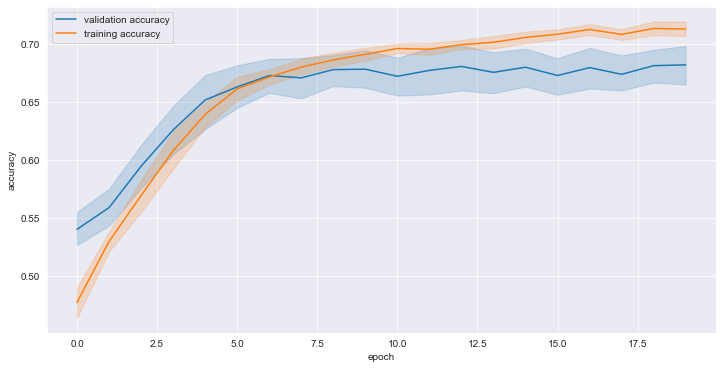

In [224]:
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(data=concat_hist, x='epoch', y='val_accuracy', label='validation accuracy')
sns.lineplot(data=concat_hist, x='epoch', y='accuracy', label='training accuracy')
ax.set_ylabel('accuracy')
plt.savefig('accuracy.jpeg')

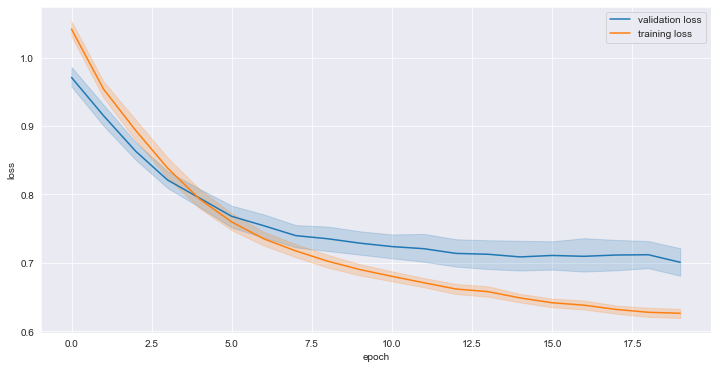

In [225]:
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(data=concat_hist, x='epoch', y='val_loss', label='validation loss')
sns.lineplot(data=concat_hist, x='epoch', y='loss', label='training loss')
ax.set_ylabel('loss')
plt.savefig('loss.jpeg')

In [118]:
RANDOM_STATE=69

In [119]:
train_x, test_x, train_y, test_y = train_test_split(data, label_data, test_size=0.2, random_state=RANDOM_STATE)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=RANDOM_STATE)

In [120]:
DROPOUT = 0.1
ALPHA = 0.1
LAYERS = [100, 10]
BATCH_SIZE = 10


EPOCHS = 20
m = build_model(LAYERS, DROPOUT, ALPHA)
m.summary()
hist = m.fit(train_x, train_y, batch_size=BATCH_SIZE, validation_data=(val_x,val_y), epochs=EPOCHS)

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 134)]             0         
                                                                 
 flatten_13 (Flatten)        (None, 134)               0         
                                                                 
 dense_39 (Dense)            (None, 100)               13500     
                                                                 
 dropout_26 (Dropout)        (None, 100)               0         
                                                                 
 dense_40 (Dense)            (None, 10)                1010      
                                                                 
 dropout_27 (Dropout)        (None, 10)                0         
                                                                 
 dense_41 (Dense)            (None, 3)                 33 

In [123]:
pred = pd.Series(np.argmax(m.predict(test_x), axis=1))
true = pd.Series(test_y.columns[np.where(test_y!=0)[1]])

6/6 [==============================] - 0s 3ms/step


In [124]:
def confusion_matrix(pred, true):
    true.name = 'target'
    pred.name = 'predicted'
    cm = pd.crosstab(true.reset_index(drop=True), pred.reset_index(drop=True))
    cm = cm[cm.index]
    return cm

In [125]:
confusion_matrix(pred, true)

predicted,0,1,2
target,,,
0,29,17,0
1,2,64,16
2,0,18,38


In [126]:
f1_score(list(true.values), list(pred.values), average='weighted')

0.7137457066114286

In [127]:
f1_score(list(true.values), list(pred.values), average='macro')

0.7171127215326111

In [128]:
accuracy_score(list(true.values), list(pred.values))

0.7119565217391305